Для лабораторной работы был выбран датасет [Credit Card customers](https://www.kaggle.com/sakshigoyal7/credit-card-customers). Будем решать задачу классификации для предсказания оттока клиентов в банке, выдающем кредитные карты.

# 0. Подготовка 

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
import numpy as np
from typing import Dict, Tuple

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import validation_curve, learning_curve

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz 
import pydotplus

In [2]:
data = pd.read_csv('data/BankChurners.csv', sep=',')

Производим удаление последних двух столбцов, как указано в описании к данному датасету

In [3]:
data.drop(columns=data.columns[[data.shape[1]-2, data.shape[1]-1]], inplace=True)

In [4]:
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [6]:
data.duplicated().sum()

0

In [7]:
col_obj = data.dtypes[data.dtypes==object].index.values.tolist()
for i in enumerate(col_obj):
    uniq_obj = data[i[1]].unique()
    print(f'{i[0]+1}. {i[1]}: {uniq_obj} | КОЛ-ВО: {len(uniq_obj)}')

1. Attrition_Flag: ['Existing Customer' 'Attrited Customer'] | КОЛ-ВО: 2
2. Gender: ['M' 'F'] | КОЛ-ВО: 2
3. Education_Level: ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate'] | КОЛ-ВО: 7
4. Marital_Status: ['Married' 'Single' 'Unknown' 'Divorced'] | КОЛ-ВО: 4
5. Income_Category: ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown'] | КОЛ-ВО: 6
6. Card_Category: ['Blue' 'Gold' 'Silver' 'Platinum'] | КОЛ-ВО: 4


Нашей целевой переменной является **Attrition_Flag**: *Existing Customer* - ещё клиент, *Attrited Customer* - ушедший клиент

In [8]:
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])
for i in range(2):
    print(f'{i}: {le.inverse_transform([i]).tolist()[0]}')

0: F
1: M


Кодируем целевую переменную в соответствии с тем, что требуется предсказать 

In [9]:
mapping = {'Existing Customer' : 0, 'Attrited Customer' : 1}
data['Attrition_Flag'] = data['Attrition_Flag'].apply(lambda x: mapping[x])

Скопируем датасет для применения к его категориальным признакам метода 'Label encoding' с целью удобства дальнейшего представления корреляционной матрицы, а также последующего применения при использовании классификатора дерева решений

In [10]:
data_copy = data
data_copy = data_copy.apply(LabelEncoder().fit_transform)

Выполняем масштабирование признаков

In [11]:
col_num = data.dtypes[data.dtypes!=object].index.values.tolist()
col_num.remove('Attrition_Flag')
col_num.remove('Gender')
se = StandardScaler()
data[col_num] = se.fit_transform(data[col_num])

Остальные категориальные признаки заполняем методом One-hot Encoding

In [12]:
data = pd.get_dummies(data, drop_first=True)

In [13]:
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0.802878,0,-0.165406,1,0.503368,0.384621,0.763943,-1.327136,0.492404,0.446622,...,0,0,0,1,0,0,0,0,0,0
1,2.156861,0,0.333570,0,2.043199,1.010715,1.407306,-1.327136,-0.411616,-0.041367,...,1,0,0,0,0,1,0,0,0,0
2,-0.682769,0,0.583058,1,0.503368,0.008965,0.120579,-1.327136,-2.219655,-0.573698,...,0,0,0,0,1,0,0,0,0,0
3,0.832862,0,-0.789126,0,1.273283,-0.241473,-0.522785,1.641478,-1.315636,-0.585251,...,0,1,0,0,0,1,0,0,0,0
4,-0.814896,0,-0.789126,1,0.503368,-1.869317,0.763943,-1.327136,-2.219655,-0.430877,...,0,0,0,1,0,0,0,0,0,0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CLIENTNUM                       10127 non-null  float64
 1   Attrition_Flag                  10127 non-null  int64  
 2   Customer_Age                    10127 non-null  float64
 3   Gender                          10127 non-null  int32  
 4   Dependent_count                 10127 non-null  float64
 5   Months_on_book                  10127 non-null  float64
 6   Total_Relationship_Count        10127 non-null  float64
 7   Months_Inactive_12_mon          10127 non-null  float64
 8   Contacts_Count_12_mon           10127 non-null  float64
 9   Credit_Limit                    10127 non-null  float64
 10  Total_Revolving_Bal             10127 non-null  float64
 11  Avg_Open_To_Buy                 10127 non-null  float64
 12  Total_Amt_Chng_Q4_Q1            

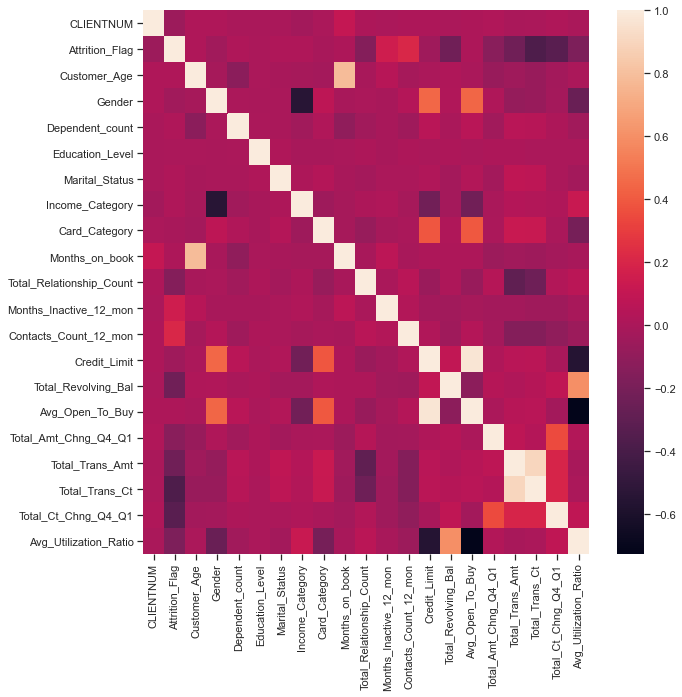

In [15]:
plt.figure(figsize=(10,10))
g = sns.heatmap(data_copy.corr())

In [16]:
data_copy.corr()['Avg_Open_To_Buy'].sort_values(ascending=False)

Avg_Open_To_Buy             1.000000
Credit_Limit                0.969841
Gender                      0.443721
Card_Category               0.395022
Dependent_count             0.059127
Total_Trans_Ct              0.057258
Total_Trans_Amt             0.054588
Contacts_Count_12_mon       0.034850
Marital_Status              0.030640
Attrition_Flag              0.013000
CLIENTNUM                   0.011690
Months_on_book              0.010220
Total_Amt_Chng_Q4_Q1        0.006124
Education_Level             0.001425
Customer_Age                0.000525
Months_Inactive_12_mon     -0.019191
Total_Ct_Chng_Q4_Q1        -0.028504
Total_Relationship_Count   -0.069629
Total_Revolving_Bal        -0.114019
Income_Category            -0.223611
Avg_Utilization_Ratio      -0.727982
Name: Avg_Open_To_Buy, dtype: float64

In [17]:
data_copy.corr()['Credit_Limit'].sort_values(ascending=False)

Credit_Limit                1.000000
Avg_Open_To_Buy             0.969841
Gender                      0.451982
Card_Category               0.390493
Total_Revolving_Bal         0.093662
Total_Trans_Ct              0.066347
Total_Trans_Amt             0.058747
Dependent_count             0.056327
Marital_Status              0.026207
Contacts_Count_12_mon       0.025860
Total_Amt_Chng_Q4_Q1        0.018750
CLIENTNUM                   0.013926
Months_on_book              0.011016
Customer_Age                0.003714
Education_Level             0.002549
Total_Ct_Chng_Q4_Q1        -0.007339
Months_Inactive_12_mon     -0.027086
Attrition_Flag             -0.043096
Total_Relationship_Count   -0.062325
Income_Category            -0.228445
Avg_Utilization_Ratio      -0.555351
Name: Credit_Limit, dtype: float64

In [18]:
data_copy.corr()['Total_Trans_Amt'].sort_values(ascending=False)

Total_Trans_Amt             1.000000
Total_Trans_Ct              0.899542
Total_Ct_Chng_Q4_Q1         0.195957
Card_Category               0.122781
Marital_Status              0.082313
Total_Amt_Chng_Q4_Q1        0.076051
Dependent_count             0.060086
Credit_Limit                0.058747
Avg_Open_To_Buy             0.054588
Income_Category             0.041160
Total_Revolving_Bal         0.022477
Education_Level             0.008195
CLIENTNUM                  -0.003452
Avg_Utilization_Ratio      -0.007327
Months_Inactive_12_mon     -0.028483
Months_on_book             -0.036141
Customer_Age               -0.042174
Gender                     -0.081912
Contacts_Count_12_mon      -0.152651
Attrition_Flag             -0.231827
Total_Relationship_Count   -0.297100
Name: Total_Trans_Amt, dtype: float64

In [19]:
data_copy.corr()['Total_Trans_Ct'].sort_values(ascending=False)

Total_Trans_Ct              1.000000
Total_Trans_Amt             0.899542
Total_Ct_Chng_Q4_Q1         0.196453
Card_Category               0.116584
Marital_Status              0.075915
Credit_Limit                0.066347
Avg_Open_To_Buy             0.057258
Dependent_count             0.049932
Total_Revolving_Bal         0.044129
Total_Amt_Chng_Q4_Q1        0.038453
Income_Category             0.033512
CLIENTNUM                   0.006369
Education_Level             0.003016
Avg_Utilization_Ratio       0.002657
Months_Inactive_12_mon     -0.042817
Months_on_book             -0.049846
Customer_Age               -0.067042
Gender                     -0.067468
Contacts_Count_12_mon      -0.152211
Total_Relationship_Count   -0.241864
Attrition_Flag             -0.371429
Name: Total_Trans_Ct, dtype: float64

In [20]:
data_copy.corr()['Attrition_Flag'].sort_values(ascending=False)

Attrition_Flag              1.000000
Contacts_Count_12_mon       0.204491
Months_Inactive_12_mon      0.152449
Dependent_count             0.018991
Marital_Status              0.018597
Customer_Age                0.018227
Income_Category             0.017584
Months_on_book              0.013687
Avg_Open_To_Buy             0.013000
Education_Level             0.005551
Card_Category              -0.006038
Gender                     -0.037272
Credit_Limit               -0.043096
CLIENTNUM                  -0.059369
Total_Amt_Chng_Q4_Q1       -0.128713
Total_Relationship_Count   -0.150005
Avg_Utilization_Ratio      -0.177846
Total_Revolving_Bal        -0.231116
Total_Trans_Amt            -0.231827
Total_Ct_Chng_Q4_Q1        -0.324012
Total_Trans_Ct             -0.371429
Name: Attrition_Flag, dtype: float64

In [21]:
dataD_copy = data_copy.drop(columns=['Avg_Open_To_Buy'])
dataD = data.drop(columns=['Avg_Open_To_Buy'])
data_copy.drop(columns=['Avg_Open_To_Buy', 'Total_Trans_Amt'], inplace=True)
data.drop(columns=['Avg_Open_To_Buy', 'Total_Trans_Amt'], inplace=True)

В результате выполнения корреляционного анализа были приняты следующие решения:
<ul>
    <li>Среди двух сильно коррелирующих признаков "Credit_Limit" (кредитный лимит по кредитной карте) и "Avg_Open_To_Buy" (Разница между кредитным лимитом, присвоенным счету держателя карты, и текущим остатком на счете (в среднем за последние 12 месяцев)) <b>был удален признак "Avg_Open_To_Buy"</b>, так как он сильнее коррелирует с другими признаками объектов и слабее коррелирует с целевым признаком</li>
    <li>Первый случай (удален 1 признак): среди двух сильно коррелирующих признаков "Total_Trans_Amt" (общая сумма транзакций за 12 мес.) и "Total_Trans_Ct" (общее количество транзакций за 12 месяцев) <b>был удален признак "Total_Trans_Amt"</b>, так как он сильнее коррелирует с остальными признаками объектов и слабее коррелирует с целевым признаком.</li>
    <li>Второй случай (удалено 2 признака): среди двух сильно коррелирующих признаков "Total_Trans_Amt" (общая сумма транзакций за 12 мес.) и "Total_Trans_Ct" (общее количество транзакций за 12 месяцев) <b>были оставлены оба</b>, так как они оба достаточно сильно коррелируют с целевым признаком.</li>
</ul>

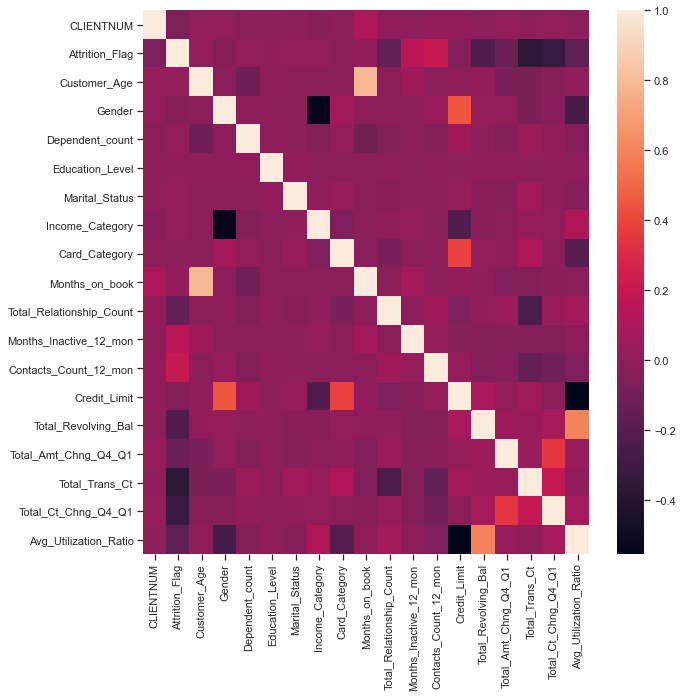

In [22]:
plt.figure(figsize=(10,10))
g = sns.heatmap(data_copy.corr())

In [23]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    """
    Вычисляет пропорции классов
    array - массив, содержащий метки классов
    """
    labels, counts = np.unique(array, return_counts=True)
    counts_perc = counts/array.size
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    """
    Вывод пропорций классов
    """
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [24]:
from imblearn.under_sampling import RandomUnderSampler

In [25]:
TEST_SIZE = 0.3
RANDOM_STATE = 0
SPLITS_DEFAULT = 5
CROSS_VAL = StratifiedKFold(n_splits=SPLITS_DEFAULT)

In [26]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
data_X, data_y = rus.fit_resample(data.drop(columns='Attrition_Flag'),  data['Attrition_Flag'])
dataD_X, dataD_y = rus.fit_resample(dataD.drop(columns='Attrition_Flag'),  dataD['Attrition_Flag'])

In [27]:
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(data_X, \
                                                                        data_y, test_size=TEST_SIZE, \
                                                                        random_state=RANDOM_STATE)
dataD_X_train, dataD_X_test, dataD_y_train, dataD_y_test = train_test_split(dataD_X, \
                                                                        dataD_y, test_size=TEST_SIZE, \
                                                                        random_state=RANDOM_STATE)

In [28]:
print_class_proportions(data_y_train)

Метка 	 Количество 	 Процент встречаемости
0 	 1113 	 	 48.88%
1 	 1164 	 	 51.12%


In [29]:
print_class_proportions(data_y_test)

Метка 	 Количество 	 Процент встречаемости
0 	 514 	 	 52.61%
1 	 463 	 	 47.39%


In [30]:
def print_metrics(X_train, Y_train, X_test, Y_test, clf):
    clf.fit(X_train, Y_train)
    target = clf.predict(X_test)
    ret = balanced_accuracy_score(Y_test, target)
    print(f'Сбалансированная оценка: {ret}')
    plot_roc_curve(clf, X_test, Y_test)
    plt.show()
    print(f'Матрица ошибок:\n {confusion_matrix(Y_test, target)}')
    print(classification_report(Y_test, target, target_names=['Existing Customer', 'Attrited Customer']))
    return ret

In [31]:
def print_gridResults(grid, p):
    print(f'Подобранный параметр: {grid.best_params_}')
    print(f'Оценка при подобранном параметре: {grid.best_score_}')
    return [grid.best_params_[p], grid.best_score_]

In [32]:
def get_optimum(clf, dist, n_iter, data_X_train, data_y_train, scoring='balanced_accuracy'):
    Random_grid = RandomizedSearchCV(clf, dist, n_iter=n_iter, \
                                      scoring=scoring, cv=CROSS_VAL, random_state=RANDOM_STATE)
    Random_grid.fit(data_X_train, data_y_train)
    res = print_gridResults(Random_grid, list(dist.keys())[0])
    return res

# 1. Logistic Regression

In [33]:
LogReg_param = {"C":uniform(loc=0, scale=100)}  # равномерное распределение между 0 и 100

## 1.1. Удален 1 признак

In [34]:
linearD = get_optimum(LogisticRegression(max_iter=10000), LogReg_param, 20, dataD_X_train, dataD_y_train)

Подобранный параметр: {'C': 71.51893663724195}
Оценка при подобранном параметре: 0.8443274807428306


Сбалансированная оценка: 0.8512261431536838


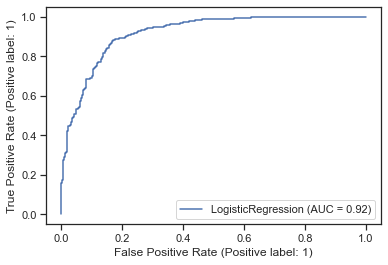

Матрица ошибок:
 [[431  83]
 [ 63 400]]
                   precision    recall  f1-score   support

Existing Customer       0.87      0.84      0.86       514
Attrited Customer       0.83      0.86      0.85       463

         accuracy                           0.85       977
        macro avg       0.85      0.85      0.85       977
     weighted avg       0.85      0.85      0.85       977



In [35]:
LRd = print_metrics(dataD_X_train, dataD_y_train, dataD_X_test, dataD_y_test, LogisticRegression(C=linearD[0], max_iter=10000))

## 1.2. Удалено 2 признака

In [36]:
linear = get_optimum(LogisticRegression(max_iter=10000), LogReg_param, 20, data_X_train, data_y_train)

Подобранный параметр: {'C': 38.34415188257777}
Оценка при подобранном параметре: 0.8222731019052523


Сбалансированная оценка: 0.824978359707877


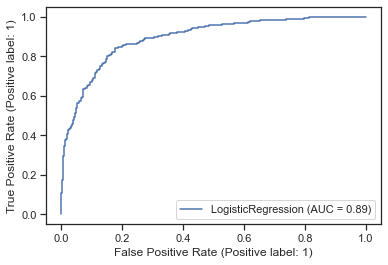

Матрица ошибок:
 [[424  90]
 [ 81 382]]
                   precision    recall  f1-score   support

Existing Customer       0.84      0.82      0.83       514
Attrited Customer       0.81      0.83      0.82       463

         accuracy                           0.82       977
        macro avg       0.82      0.82      0.82       977
     weighted avg       0.83      0.82      0.83       977



In [37]:
LR = print_metrics(data_X_train, data_y_train, data_X_test, data_y_test, LogisticRegression(C=linear[0], max_iter=10000))

# 2. SVM

In [38]:
SVM_param = {"C":uniform(loc=0, scale=100)}  # равномерное распределение между 0 и 100

## 2.1. Удален 1 признак

In [39]:
svmD = get_optimum(SVC(random_state=RANDOM_STATE), SVM_param, 3, dataD_X_train, dataD_y_train)

Подобранный параметр: {'C': 54.88135039273247}
Оценка при подобранном параметре: 0.869575441397712


Сбалансированная оценка: 0.893145279895118


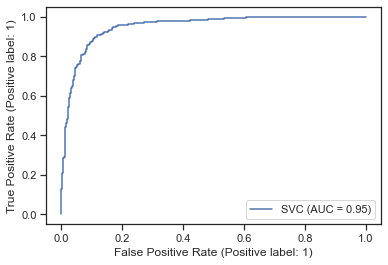

Матрица ошибок:
 [[453  61]
 [ 44 419]]
                   precision    recall  f1-score   support

Existing Customer       0.91      0.88      0.90       514
Attrited Customer       0.87      0.90      0.89       463

         accuracy                           0.89       977
        macro avg       0.89      0.89      0.89       977
     weighted avg       0.89      0.89      0.89       977



In [40]:
SVMd = print_metrics(dataD_X_train, dataD_y_train, dataD_X_test, dataD_y_test, SVC(random_state=RANDOM_STATE, C=svmD[0]))

## 2.2. Удалено 2 признака

In [41]:
svm = get_optimum(SVC(random_state=RANDOM_STATE), SVM_param, 3, data_X_train, data_y_train)

Подобранный параметр: {'C': 54.88135039273247}
Оценка при подобранном параметре: 0.8471342397891911


Сбалансированная оценка: 0.8680761570202788


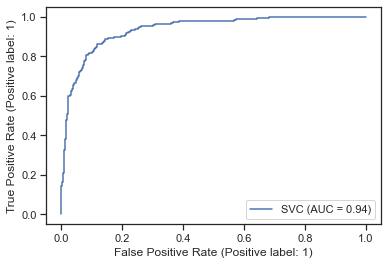

Матрица ошибок:
 [[435  79]
 [ 51 412]]
                   precision    recall  f1-score   support

Existing Customer       0.90      0.85      0.87       514
Attrited Customer       0.84      0.89      0.86       463

         accuracy                           0.87       977
        macro avg       0.87      0.87      0.87       977
     weighted avg       0.87      0.87      0.87       977



In [42]:
SVM = print_metrics(data_X_train, data_y_train, data_X_test, data_y_test, SVC(random_state=RANDOM_STATE, C=svm[0]))

# 3. Дерево решений

In [43]:
dataL_X, dataL_y = rus.fit_resample(data_copy.drop(columns='Attrition_Flag'),  data_copy['Attrition_Flag'])
dataLD_X, dataLD_y = rus.fit_resample(dataD_copy.drop(columns='Attrition_Flag'),  dataD_copy['Attrition_Flag'])

In [44]:
dataL_X_train, dataL_X_test, dataL_y_train, dataL_y_test = train_test_split(dataL_X, dataL_y, test_size=TEST_SIZE, \
                                                                        random_state=RANDOM_STATE)
dataLD_X_train, dataLD_X_test, dataLD_y_train, dataLD_y_test = train_test_split(dataLD_X, dataLD_y, test_size=TEST_SIZE, \
                                                                        random_state=RANDOM_STATE)

In [45]:
Tree_param = {"max_depth":randint(1, 10)}  # целочисленное распределение между 1 и 10

## 3.1. Удален 1 признак

In [46]:
treeD = get_optimum(DecisionTreeClassifier(random_state=RANDOM_STATE), Tree_param, 10, dataLD_X_train, dataLD_y_train)

Подобранный параметр: {'max_depth': 8}
Оценка при подобранном параметре: 0.9002867748031624


Сбалансированная оценка: 0.8970363304787756


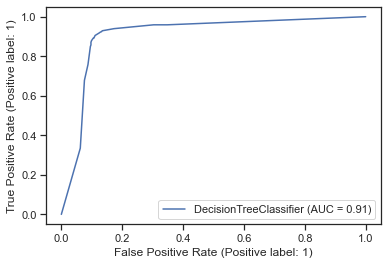

Матрица ошибок:
 [[457  57]
 [ 44 419]]
                   precision    recall  f1-score   support

Existing Customer       0.91      0.89      0.90       514
Attrited Customer       0.88      0.90      0.89       463

         accuracy                           0.90       977
        macro avg       0.90      0.90      0.90       977
     weighted avg       0.90      0.90      0.90       977



In [47]:
DTd = print_metrics(dataLD_X_train, dataLD_y_train, dataLD_X_test, dataLD_y_test, DecisionTreeClassifier(max_depth=treeD[0], \
                                                                                               random_state=RANDOM_STATE))

In [48]:
tr_clfD = DecisionTreeClassifier(max_depth=treeD[0], random_state=RANDOM_STATE)
tr_clfD.fit(dataLD_X_train, dataLD_y_train)

DecisionTreeClassifier(max_depth=8, random_state=0)

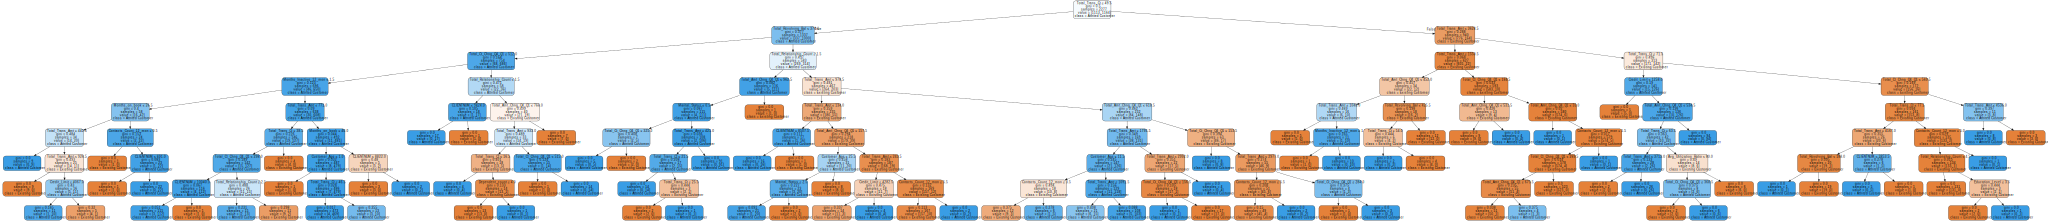

In [49]:
dot_data = export_graphviz(tr_clfD, out_file=None, 
                           feature_names=dataLD_X_train.columns.tolist(), 
                           class_names=['Existing Customer', 'Attrited Customer'], 
                           filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [50]:
def show_feature_importance(importance, col_names):
    data = pd.DataFrame({'feature_names':np.array(col_names),'feature_importance':np.array(importance)})
    data.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,7))
    sns.barplot(x=data['feature_importance'], y=data['feature_names'])
    plt.title('Feature importance using DecisionTreeClassifier')
    plt.xlabel('importance')
    plt.ylabel('name')

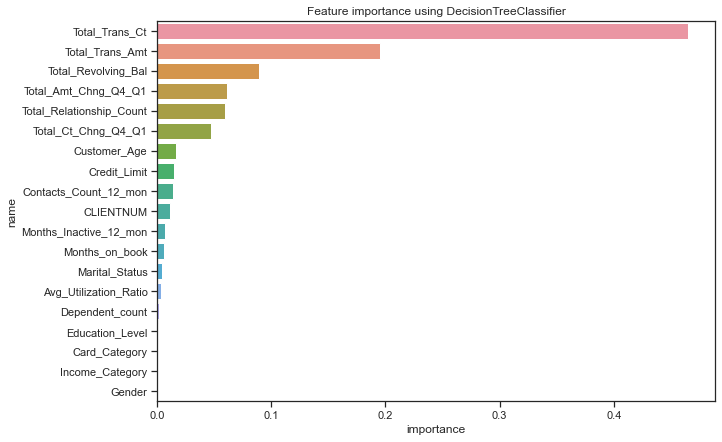

In [51]:
show_feature_importance(tr_clfD.feature_importances_, dataLD_X_train.columns.tolist())

## 3.2. Удалено 2 признака

In [52]:
tree = get_optimum(DecisionTreeClassifier(random_state=RANDOM_STATE), Tree_param, 10, dataL_X_train, dataL_y_train)

Подобранный параметр: {'max_depth': 6}
Оценка при подобранном параметре: 0.8439906922693083


Сбалансированная оценка: 0.8231651973678682


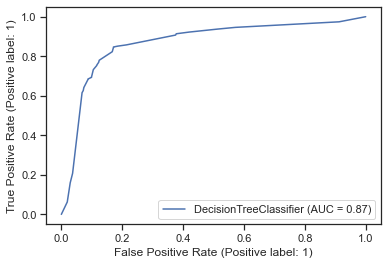

Матрица ошибок:
 [[451  63]
 [107 356]]
                   precision    recall  f1-score   support

Existing Customer       0.81      0.88      0.84       514
Attrited Customer       0.85      0.77      0.81       463

         accuracy                           0.83       977
        macro avg       0.83      0.82      0.82       977
     weighted avg       0.83      0.83      0.83       977



In [53]:
DT = print_metrics(dataL_X_train, dataL_y_train, dataL_X_test, dataL_y_test, DecisionTreeClassifier(max_depth=tree[0], \
                                                                                               random_state=RANDOM_STATE))

In [54]:
tr_clf = DecisionTreeClassifier(max_depth=tree[0], random_state=RANDOM_STATE)
tr_clf.fit(dataL_X_train, dataL_y_train)

DecisionTreeClassifier(max_depth=6, random_state=0)

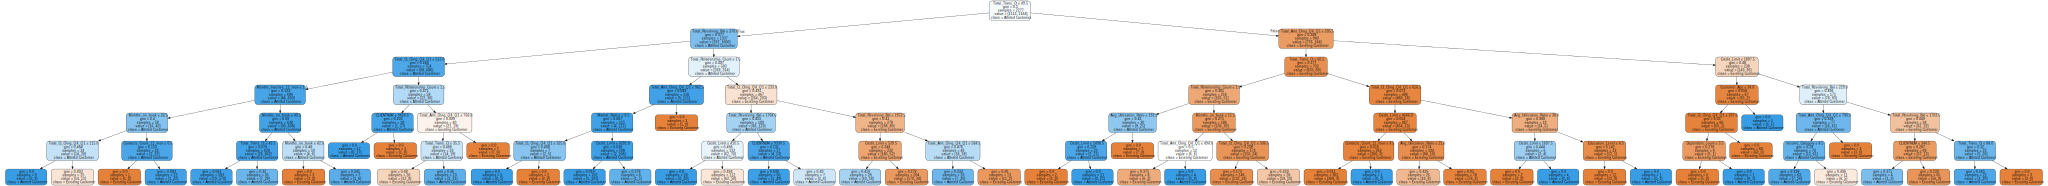

In [55]:
dot_data = export_graphviz(tr_clf, out_file=None, 
                           feature_names=dataL_X_train.columns.tolist(), 
                           class_names=['Existing Customer', 'Attrited Customer'], 
                           filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

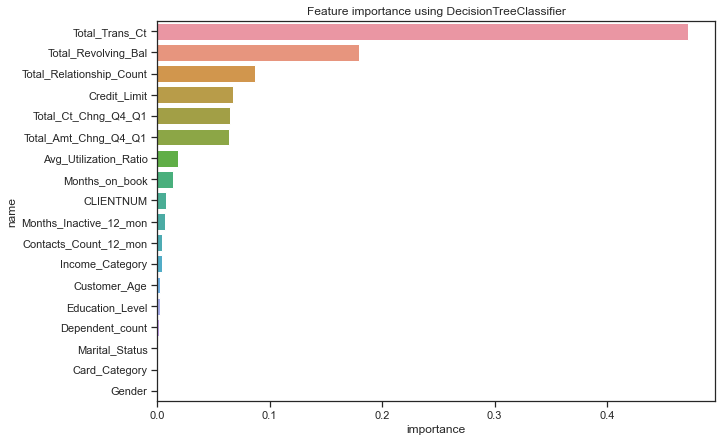

In [56]:
show_feature_importance(tr_clf.feature_importances_, dataL_X_train.columns.tolist())

# 4. Кривые обучения

In [57]:
def plot_learning_curve(data_X, data_y, clf):
    train_sizes, train_scores, test_scores = learning_curve(estimator=clf, X=data_X, y=data_y,
                                                            train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=f'тренировочная верность')
    plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
             label=f'проверочная верность')
    plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
    plt.grid()
    plt.legend(loc='upper right')
    plt.xlabel('Число тренировочных образцов')
    plt.ylabel('Верность')
    plt.show()

**Кривая обучения с удалением 1-го признака**

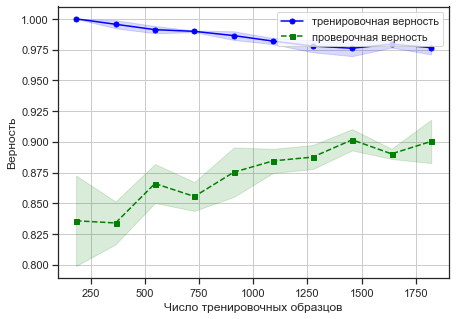

In [58]:
plot_learning_curve(dataLD_X_train, dataLD_y_train, tr_clfD)

**Кривая обучения с удалением 2-х признаков**

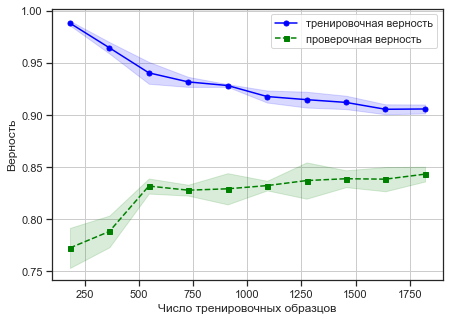

In [59]:
plot_learning_curve(dataL_X_train, dataL_y_train, tr_clf)

# 5. Итоги

In [60]:
lst_label_cv = ['LR', 'SVM', 'DT']
dc_score = {'Удален 1 признак':[LRd, SVMd, DTd],\
           'Удалено 2 признака':[LR, SVM, DT]}

## 5.1. Метрика balanced_accuracy

In [61]:
pd.DataFrame(dc_score, index=lst_label_cv)

,Удален 1 признак,Удалено 2 признака
LR,0.851226,0.824978
SVM,0.893145,0.868076
DT,0.897036,0.823165


## 5.2. Метрика ROC_CURVE

### Удален 1 признак

**LR**

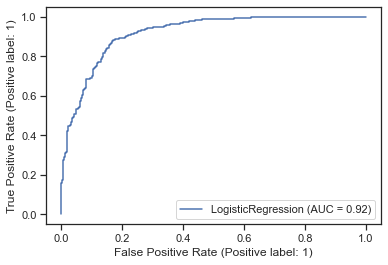

In [62]:
plot_roc_curve(LogisticRegression(C=linearD[0], max_iter=10000).fit(dataD_X_train, dataD_y_train), \
               dataD_X_test, dataD_y_test)

**SVM**

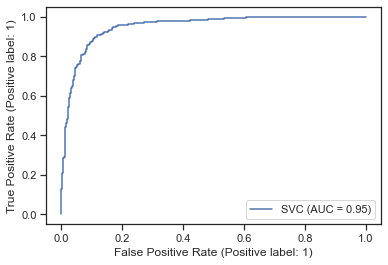

In [63]:
plot_roc_curve(SVC(random_state=RANDOM_STATE, C=svmD[0]).fit(dataD_X_train, dataD_y_train), \
               dataD_X_test, dataD_y_test)

**DT**

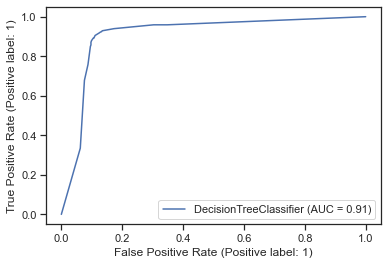

In [64]:
plot_roc_curve(DecisionTreeClassifier(max_depth=treeD[0], random_state=RANDOM_STATE).fit(dataLD_X_train, \
               dataLD_y_train), dataLD_X_test, dataLD_y_test)

### Удалено 2 признака

**LR**

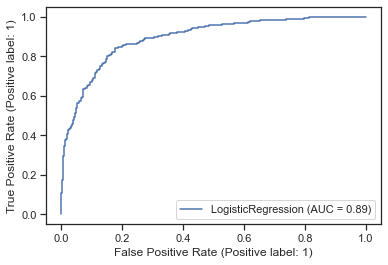

In [65]:
plot_roc_curve(LogisticRegression(C=linear[0], max_iter=10000).fit(data_X_train, data_y_train), \
               data_X_test, data_y_test)

**SVM**

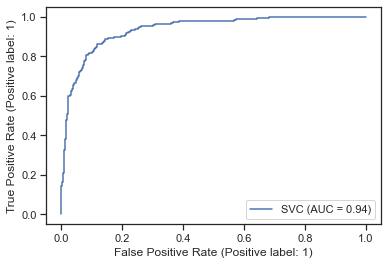

In [66]:
plot_roc_curve(SVC(random_state=RANDOM_STATE, C=svm[0]).fit(data_X_train, data_y_train), data_X_test, data_y_test)

**DT**

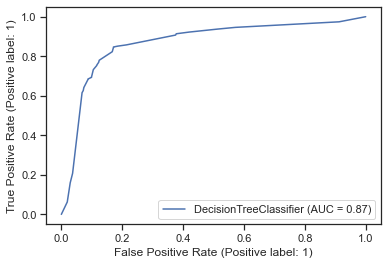

In [67]:
plot_roc_curve(DecisionTreeClassifier(max_depth=tree[0], random_state=RANDOM_STATE).fit(dataL_X_train, \
               dataL_y_train), dataL_X_test, dataL_y_test)